In [16]:
import json, sys
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append("/mnt/data/datasets/cn_sordos_db")
from type_hints import CutData


plt.style.use("ggplot")
plt.rcParams.update({'font.size': 18})
color="dodgerblue"
figs_path = Path("../data/graphs/samples")
figs_path.mkdir(exist_ok=True)

def save_fig(fig, name: str, path: Path):
    fig.get_figure().savefig(path.resolve() / name, bbox_inches = 'tight')

def clean_word(word: str, chars: list[str], rep: str = '') -> str:
    for c in chars:
        word = word.replace(c,rep)
    return word

inv_chars = ['\n', ',', '.', '"', '-', '?', '!', '¿', '¡', '_']

# cuts data contains list of data for each cut json file
cuts_data: list[CutData] = []
# words contain list of words for each cut, excepting stopwords
words: dict[str, list[str]] = {}
# times contain lenght (s) for each cut
times: dict[str, float] = {}
# videos contains videos names
videos: set[str] = set()

path = Path("../data/cuts/")
cuts = map(lambda p: Path(str(p.resolve())[:-3] + "json"), path.glob('**/*.mp4'))

for idx, cut in enumerate(cuts):
    with cut.open() as datafile:
        data: CutData = json.load(datafile)
    cuts_data.append(data)
    words[str(cut)] = [w for w in clean_word(data['label'], inv_chars, ' ').lower().split(' ') if w]
    times[str(cut)] = (data['end'] - data['start'])
    videos.add(data['video'])

print(f'''La base de datos contiene:
    {len(videos)} videos completos
    {len(cuts_data)} clips resultantes de dividir los videos de acuerdo a los subtítulos
    {(sum(times.values())/60)/60} hs de video''')

La base de datos contiene:
    64 videos completos
    14880 clips resultantes de dividir los videos de acuerdo a los subtítulos
    21.78172527777782 hs de video


Videos por playlist

count        4.000000
mean      3720.000000
std       6659.176125
min         44.000000
25%         99.500000
50%        575.000000
75%       4195.500000
max      13686.000000
dtype: float64

<AxesSubplot:>

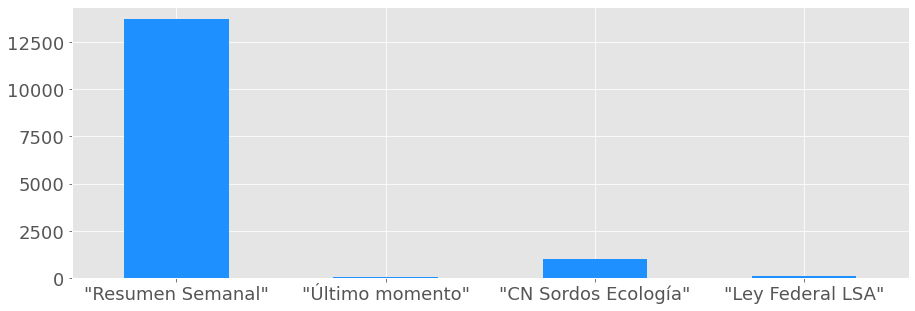

In [52]:
playlists_names = {
    'resumen_semanal': '"Resumen Semanal"',
    'ultimo_momento': '"Último momento"',
    'ecologia': '"CN Sordos Ecología"',
    'ley_federal_lsa': '"Ley Federal LSA"'
}

playlist_s: pd.Series = pd.Series(Counter(map(lambda cd: playlists_names[cd['playlist']], cuts_data)))
display(playlist_s.describe())
playlists_fig = playlist_s.plot.bar(figsize=(15,5), color=color)
plt.xticks(rotation=0)
display(playlists_fig)
save_fig(playlists_fig, "videos_by_playlists.png", figs_path)

Estadísticas de la duración de los clips:

count    14880.000000
mean         5.269772
std          2.732944
min          0.450000
25%          3.330000
50%          4.670000
75%          6.540000
max         25.580000
dtype: float64

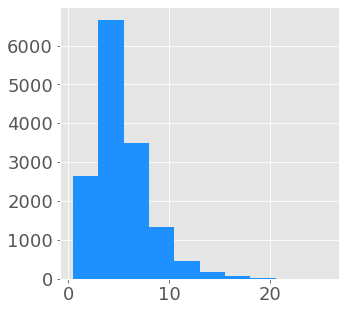

In [4]:
clip_times_s = pd.Series(times)
display(clip_times_s.describe())
clip_times_hist_fig = clip_times_s.plot.hist(figsize=(5,5), color="dodgerblue")
clip_times_hist_fig.set_ylabel("")
save_fig(clip_times_hist_fig, "clip_times_hist.png", figs_path)

Estadísticas de cantidad de palabras por clip:

count    14880.000000
mean         4.784812
std          1.817335
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max         14.000000
dtype: float64

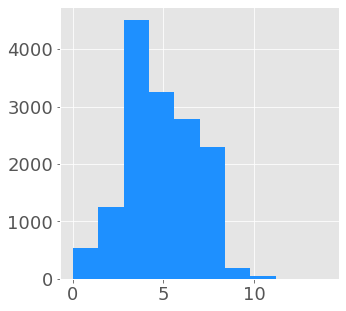

In [5]:
words_per_vid_s = pd.Series({k: len(v) for k, v in words.items()})
display(words_per_vid_s.describe())
words_per_vid_fig = words_per_vid_s.plot.hist(figsize=(5, 5), color="dodgerblue")
words_per_vid_fig.set_ylabel("")
save_fig(words_per_vid_fig, "words_per_vid_hist.png", figs_path)

Estadísticas sobre palabras por frecuencia

count      10.000000
mean     1423.800000
std      2123.763525
min       162.000000
25%       271.750000
50%       598.500000
75%      1442.750000
max      7150.000000
dtype: float64

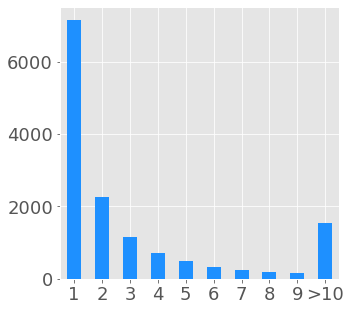

In [53]:
from typing import Callable
from pandas import Index


total_words = [word for label in words.values() for word in label]
word_count = Counter(total_words)

def get_sort_key(other_symbol: str, other_val: int):
    def sort_key(i: Index):
        return list(map(lambda i: int(i) if i != other_symbol else other_val, i))
    return sort_key

def word_freqs_range(word_count: Counter[str], group_key: Callable[[int], bool], other_symbol: str):
    return Counter([(str(v) if not group_key(v) else other_symbol) for (_,v) in word_count.items()])

max_freq = 10
words_hist_range_max = word_freqs_range(word_count, lambda v: v>=max_freq, f">{max_freq}")
words_hist_range_max_s = pd.Series(words_hist_range_max).sort_index(key=get_sort_key(f">{max_freq}", max_freq))

display(words_hist_range_max_s.describe())
words_hist_range_max_fig = words_hist_range_max_s.plot.bar(figsize=(5, 5), color=color)
words_hist_range_max_fig.set_ylabel("")
plt.xticks(rotation=360)
save_fig(words_hist_range_max_fig, f"words_hist_range_max_{max_freq}.png", figs_path)

count     81.000000
mean      15.469136
std       22.685395
min        1.000000
25%        3.000000
50%        5.000000
75%       17.000000
max      107.000000
dtype: float64

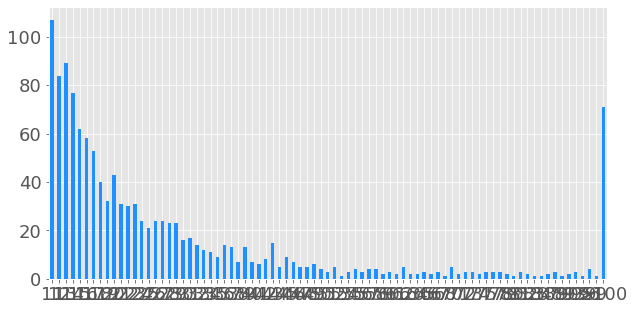

In [48]:
words_filtered = {k:v for (k,v) in word_count.items() if v>10}

max_freq = 100
words_filtered_hist_range_max = word_freqs_range(words_filtered, lambda v: v>=max_freq, f">{max_freq}")
words_filtered_hist_range_max_s = pd.Series(words_filtered_hist_range_max).sort_index(key=get_sort_key(f">{max_freq}", max_freq))

display(words_filtered_hist_range_max_s.describe())
words_filtered_hist_range_max_fig = words_filtered_hist_range_max_s.plot.bar(figsize=(10, 5), color=color)
words_filtered_hist_range_max_fig.set_ylabel("")
plt.xticks(rotation=360)
save_fig(words_filtered_hist_range_max_fig, f"words_hist_range_max_{max_freq}.png", figs_path)

count       21.000000
mean       668.190476
std       3057.221739
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max      14011.000000
dtype: float64

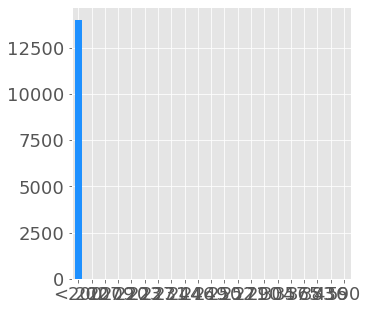

In [39]:
min_freq = 200
words_hist_range_min = word_freqs_range(lambda v: v<=min_freq, f"<{min_freq}")
words_hist_range_min_s = pd.Series(words_hist_range_min).sort_index(key=get_sort_key(f"<{min_freq}", min_freq))

display(words_hist_range_min_s.describe())
words_hist_range_min_fig = words_hist_range_min_s.plot.bar(figsize=(5, 5), color=color)
words_hist_range_min_fig.set_ylabel("")
plt.xticks(rotation=360)
save_fig(words_hist_range_min_fig, f"words_hist_range_min_{min_freq}.png", figs_path)

Estadísticas acerca de palabras mas frecuentes:

count    14238.000000
mean         9.563913
std        113.766985
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       7595.000000
dtype: float64

<AxesSubplot:>

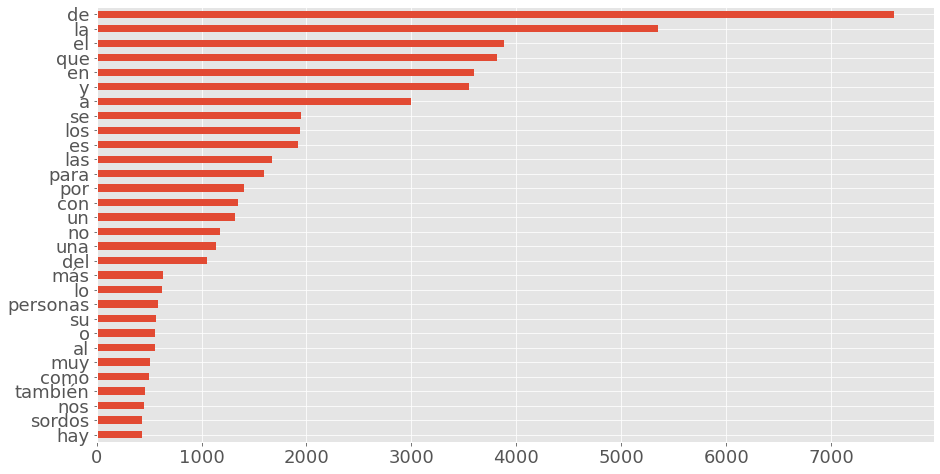

In [54]:
total_words_s = pd.Series(word_count).sort_values(ascending=False)
display(total_words_s.describe())
display(total_words_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

count    70809.000000
mean         1.923075
std          7.558147
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       1029.000000
dtype: float64

<AxesSubplot:>

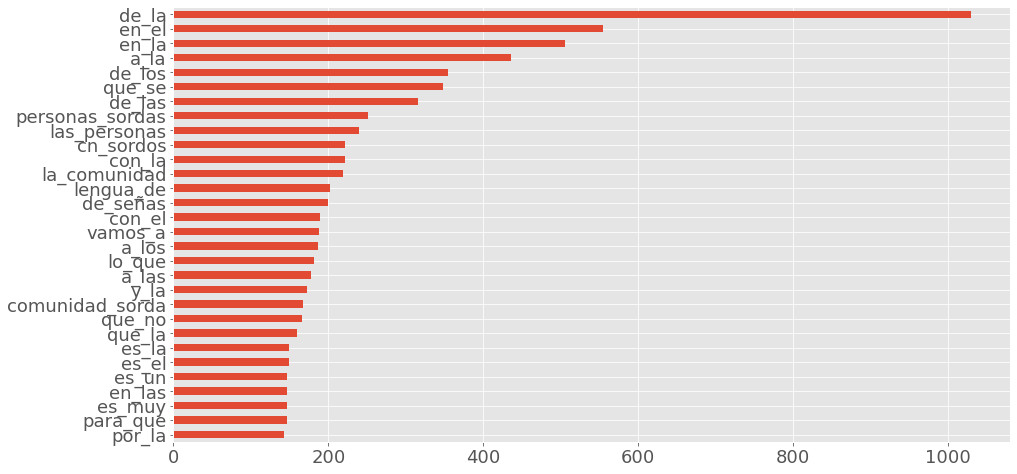

In [55]:
total_bigrams = ['_'.join(total_words[i:i + 2]) for i in range(len(total_words))]
bigram_count = Counter(total_bigrams)

total_bigrams_s = pd.Series(bigram_count).sort_values(ascending=False)
display(total_bigrams_s.describe())
display(total_bigrams_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))

count    113114.000000
mean          1.203839
std           1.524150
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         192.000000
dtype: float64

<AxesSubplot:>

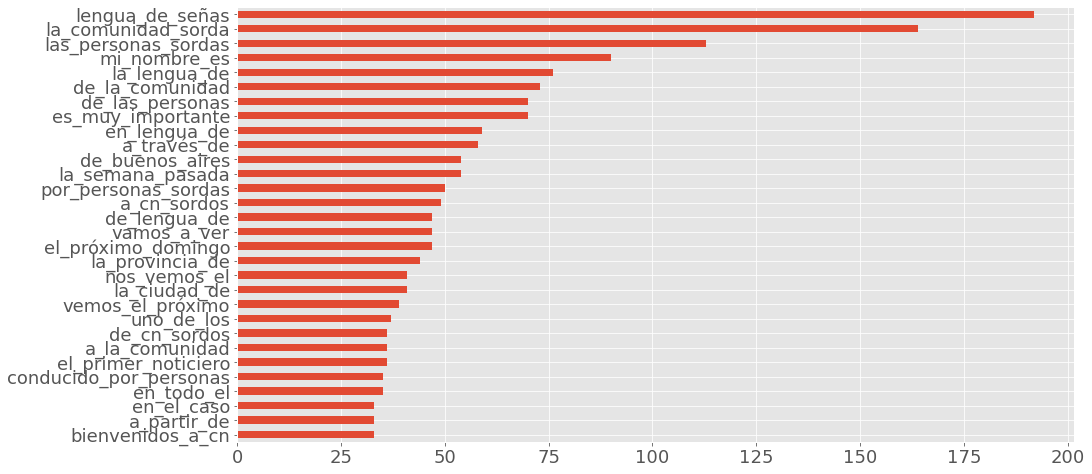

In [56]:
total_trigrams = ['_'.join(total_words[i:i + 3]) for i in range(len(total_words))]
trigram_count = Counter(total_trigrams)

total_trigrams_s = pd.Series(trigram_count).sort_values(ascending=False)
display(total_trigrams_s.describe())
display(total_trigrams_s.iloc[:30].sort_values().plot.barh(figsize=(15,8)))